# Ground-roll attenuation model with attention. 1D
## Attention branch as regression of noise mask parameters

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/gazprom-neft/SeismicPro/blob/master/datasets/ground-roll_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import sys
sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import shutil
import pprint

import numpy as np
from scipy import signal
import pandas as pd

from tqdm import tqdm


import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import patches


from seismicpro.batchflow import Pipeline, V, B, L, I, W

from seismicpro.batchflow.batchflow.models.tf import UNet, VGG7, VGG16
from seismicpro.batchflow.batchflow.models.tf.nn.activations import h_sigmoid

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import attention_loss_gauss


from Ground_Roll.src.utils import make_index, load_arrs
from Ground_Roll.src.unet_att2_params import UnetAttParams

%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


Index dataset

In [2]:
!ls -lh /notebooks/data/H1_WZ/NA

total 3.7G
-rw-r--r-- 1 root root 1.9G Nov 14 08:01 1_NA-gr_input_DN01.sgy
-rw-r--r-- 1 root root 1.9G Nov 14 08:01 1_NA-gr_output_DN03.sgy


In [3]:
paths = dict(raw = '/notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy',
             lift = '/notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy',
             m1 = os.path.abspath('1_model_inference/H1_WZ_train_test_unet_att_params_1_1.sgy'),
             m3 = os.path.abspath('3_model_inference/H1_WZ_unet_att_params_model_noise_1.sgy'),
            )
components = list(sorted(paths.keys()))

index = make_index(paths, extra_headers=['offset'])
index.head()

offset TraceNumber TRACE_SEQUENCE_FILE  \
                                              lift   
FieldRecord                                          
111906         326        1512                   1   
111906         326        1513                   2   
111906         333        1511                   3   
111906         334        1514                   4   
111906         348        1515                   5   

                                                      file_id  \
                                                         lift   
FieldRecord                                                     
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy   
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy   
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy   
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy   
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy   

            TRACE_SEQUENCE_FILE  \
                             m1   
FieldRecord                       
111906                        1   
111906                        2   
111906                        3   
111906                        4   
111906                        5   

                                                       file_id  \
                                                            m1   
FieldRecord                                                      
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   

            TRACE_SEQUENCE_FILE  \
                             m3   
FieldRecord                       
111906                        1   
111906                        2   
111906                        3   
111906                        4   
111906                        5   

                                                       file_id  \
                                                            m3   
FieldRecord                                                      
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   
111906       /notebooks/tonya/SeismicPro/SeismicPro/Ground_...   

            TRACE_SEQUENCE_FILE  \
                            raw   
FieldRecord                       
111906                        1   
111906                        2   
111906                        3   
111906                        4   
111906                        5   

                                                     file_id  
                                                         raw  
FieldRecord                                                   
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy  
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy  
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy  
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy  
111906       /notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy

In [4]:
len(index)

101

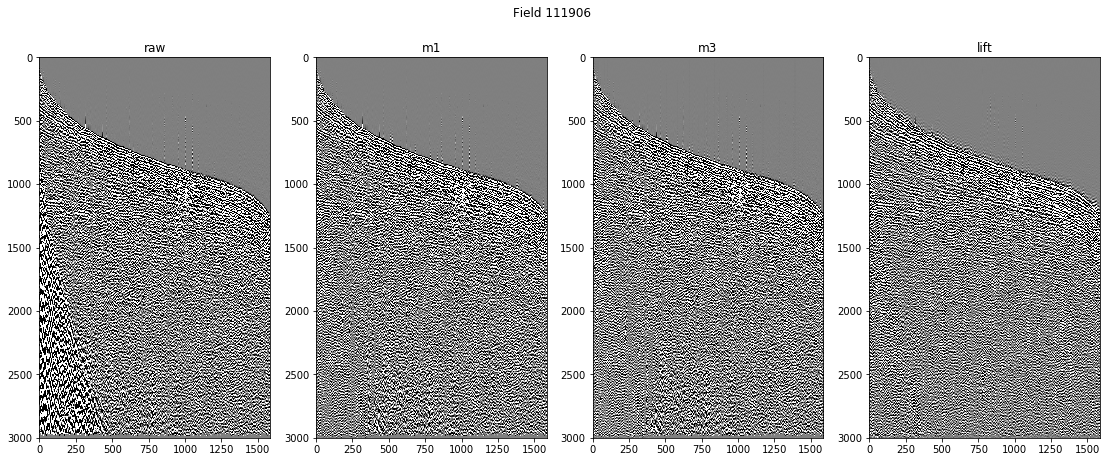

In [5]:
def check_res(i, index, cv=0.1):  
    
    arrs = load_arrs(i, index, components=components)   
    seismic_plot(list(arrs.values()), names=list(arrs.keys()),
                 figsize=(19, 7), cmap='gray', vmin=-cv, vmax=cv, title='Field {}'.format(index.indices[i]))
    
    return arrs

arrs = check_res(0, index)

Run test pipeline:

In [6]:
lift = arrs['lift']
raw = arrs['raw']
m1 = arrs['m1']
m3 = arrs['m3']
arrs.keys()

dict_keys(['raw', 'm1', 'm3', 'lift'])

In [7]:
def make_tiles(arr, hlen, vlen):
    # i, j - num parts to split
    
    x0, x1 = arr.shape
    
    i = x0//hlen
    j = x1//vlen
    splits = np.split(arr[:hlen*i], i)
    splits = [np.split(s[:,:vlen*j], j, axis=1) for s in splits]
    
    return splits

def assemble(splits):
    return np.vstack(np.hstack(l) for l in splits)

In [8]:
def corr_heatmap(arr, hlen, vlen, avg=False, dropna=True):
    splits = make_tiles(arr, hlen, vlen)
    corrs = [[np.corrcoef(t) - np.eye(t.shape[0]) for t in l] for l in splits]
    if avg:
        corrs = [[np.abs(np.nanmean(c) if dropna else np.mean(c)) for c in l] for l in corrs]
    return(assemble(corrs))
    

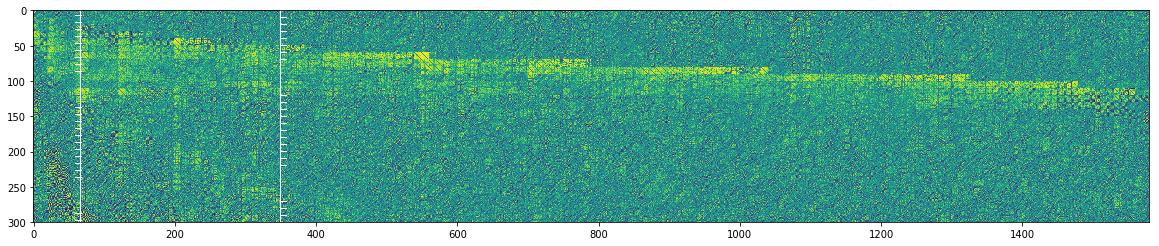

In [9]:
plt.figure( figsize=(20,20))
tmp = corr_heatmap(raw, 10, 100)
plt.imshow(tmp.T)

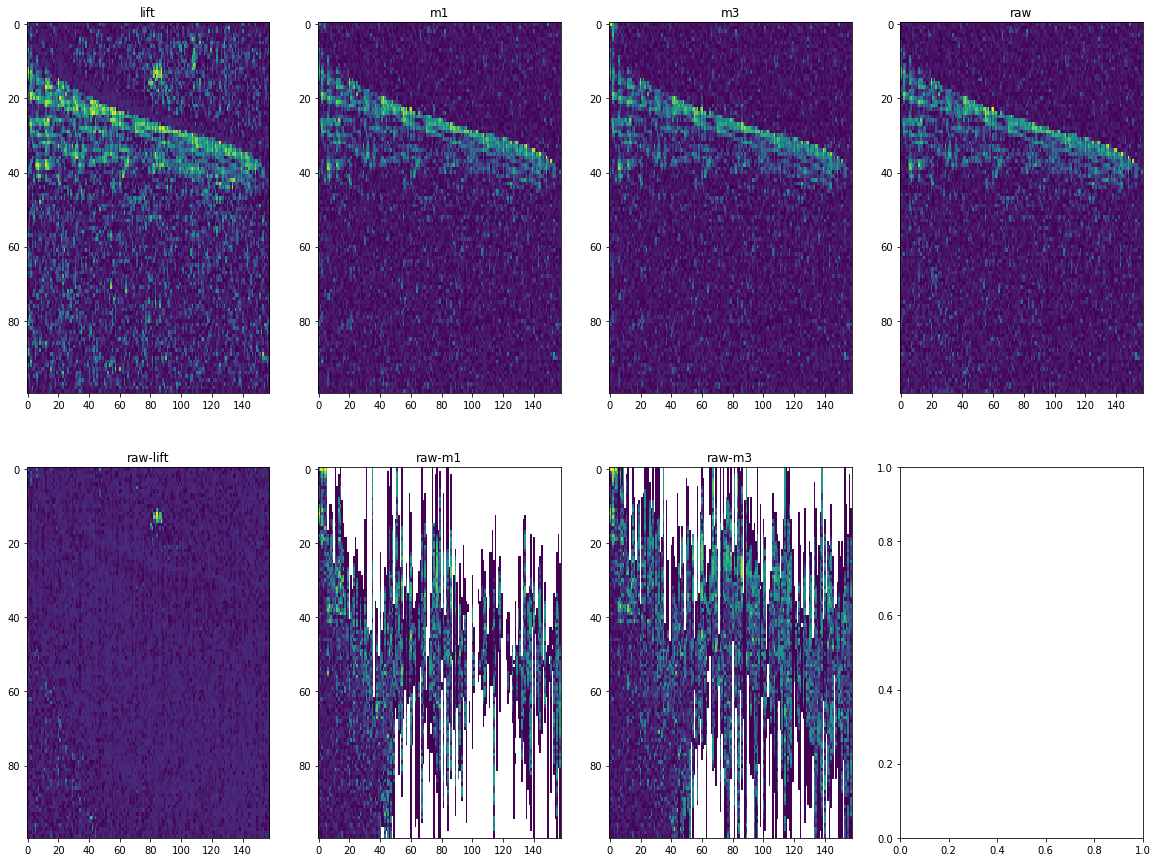

In [10]:
data = {'lift': lift, 'm1': m1, 'm3': m3, 'raw': raw, 'raw-lift': raw-lift, 'raw-m1': raw-m1, 'raw-m3': raw-m3}
fig, ax = plt.subplots(2, np.ceil(len(data)/2).astype(int), figsize=(20,15))

ax = ax.flatten()
for i, (title, arr) in enumerate(sorted(data.items())): 
    tmp = corr_heatmap(arr, 10, 30, avg=True)
    ax[i].imshow(tmp.T, vmin=0)
    ax[i].set_title(title)
    ax[i].set_aspect('auto')
    


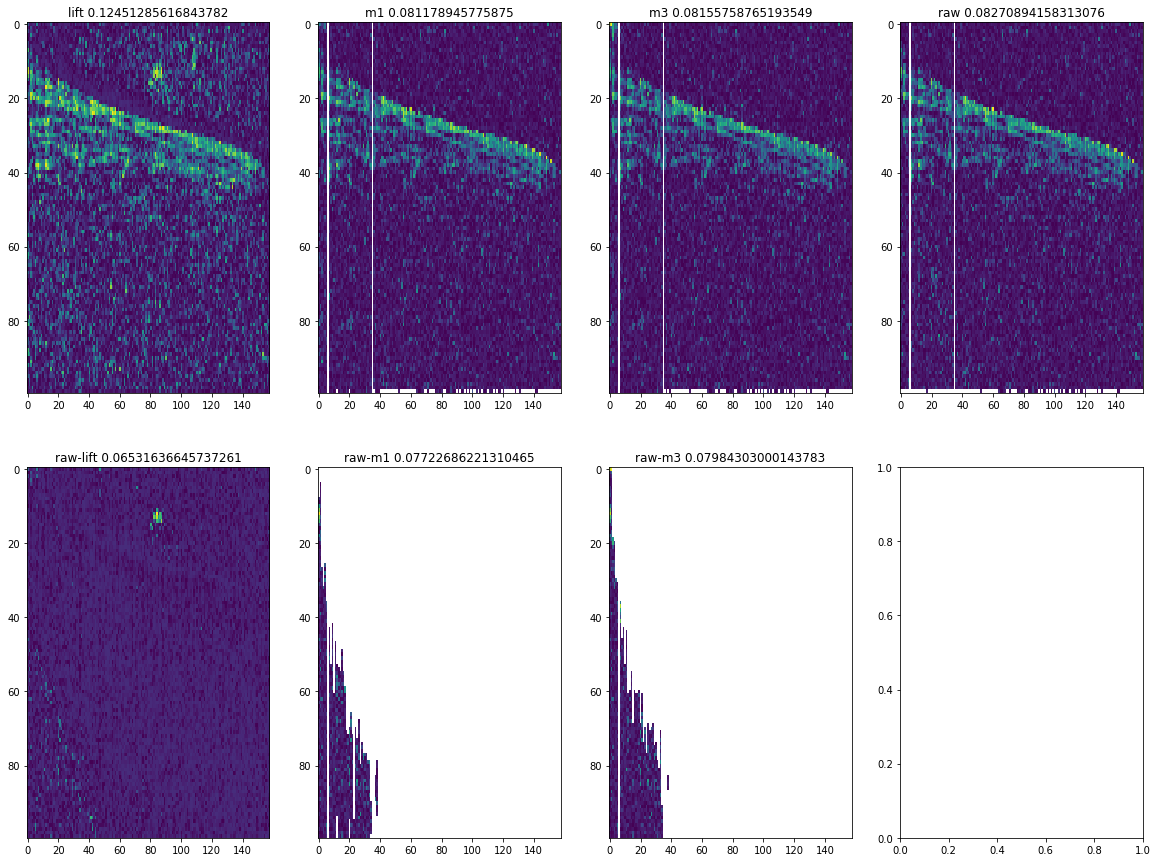

In [11]:
data = {'lift': lift, 'm1': m1, 'm3': m3, 'raw': raw, 'raw-lift': raw-lift, 'raw-m1': raw-m1, 'raw-m3': raw-m3}
fig, ax = plt.subplots(2, np.ceil(len(data)/2).astype(int), figsize=(20,15))

ax = ax.flatten()
for i, (title, arr) in enumerate(sorted(data.items())): 
    tmp = corr_heatmap(arr, 10, 30, avg=True, dropna=False)
    ax[i].imshow(tmp.T, vmin=0)
    ax[i].set_title(title + ' ' + str(np.nanmean(tmp)))
    ax[i].set_aspect('auto')

In [12]:
def get_windowed_spectrogram_dists(smgr, smgl, dist_fn='sum_abs',
                                   time_frame_width=100, noverlap=None, window='boxcar'):
    """
    Calculates distances between traces' spectrograms in sliding windows

    Parameters
    ----------
    smgr, smgl : np.array of shape (traces count, timestamps)
        traces to compute spectrograms on

    dist_fn : 'max_abs', 'sum_abs', 'sum_sq' or callable, optional
        function to calculate distance between 2 specrograms for single trace and single time window
        if callable, should accept 2 arrays of shape (traces count, frequencies, segment times)
        and operate on second axis
        Default is 'sum_abs'

    time_frame_width : int, optional
        nperseg for signal.spectrogram
        see ::meth:: scipy.signal.spectrogram

    noverlap : int, optional
        see ::meth:: scipy.signal.spectrogram

    window : str or tuple or array_like, optional
        see ::meth:: scipy.signal.spectrogram

    Returns
    -------
    np.array of shape (traces count, segment times) with distance heatmap
    """
    kwargs = dict(window=window, nperseg=time_frame_width, noverlap=noverlap, mode='complex')
    *_, spgl = signal.spectrogram(smgl, **kwargs)
    *_, spgr = signal.spectrogram(smgr, **kwargs)

    funcs = {
        'max_abs': lambda spgl, spgr: np.abs(spgl - spgr).max(axis=1),
        'sum_abs': lambda spgl, spgr: np.sum(np.abs(spgl - spgr), axis=1),
        'sum_sq': lambda spgl, spgr: np.sum(np.abs(spgl - spgr) ** 2, axis=1)
    }
    a_l = np.abs(spgl) ** 2 * 2
    a_r = np.abs(spgr) ** 2 * 2

    if callable(dist_fn):  # res(sl, sr)
        res_a = dist_fn(a_l, a_r)
    elif dist_fn in funcs:
        res_a = funcs[dist_fn](a_l, a_r)
    else:
        raise NotImplementedError('modes other than max_abs, sum_abs, sum_sq not implemented yet')

    return res_a


def draw_modifications_dist(modifications, traces_frac=0.1, distances='sum_abs',  # pylint: disable=too-many-arguments
                            vmin=None, vmax=None, figsize=(15, 15),
                            time_frame_width=100, noverlap=0, window='boxcar',
                            n_cols=None, fontsize=20, aspect=None,
                            save_to=None):
    """
    Draws seismograms with distances computed relative to 1-st given seismogram

    Parameters
    ----------
    modifications : list of tuples (np.array, str)
        each tuple represents a seismogram and its label
        traces in seismograms should be ordered by absolute offset increasing

    traces_frac : float, optional
        fraction of traces to use to compute metrics

    distances : list of str or callables, or str, or callable, optional
        dist_fn to pass to get_windowed_spectrogram_dists
        if list is given, all corresponding metrics values are computed

    vmin, vmax, figsize :
        parameters to pass to pyplot.imshow

    time_frame_width, noverlap, window :
        parameters to pass to get_windowed_spectrogram_dists

    n_cols : int or None, optional
        If int, resulting plots are arranged in n_cols collumns, and several rows, if needed
        if None, resulting plots are arranged in one row

    fontsize : int
        fontsize to use in Axes.set_title

    aspect : 'equal', 'auto', or None
        aspect to pass to Axes.set_aspect. If None, set_aspect is not called
    """

    x, y = 1, len(modifications)
    if n_cols is not None:
        x, y = int(np.ceil(y / n_cols)), n_cols

    _, axs = plt.subplots(x, y, figsize=figsize)

    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    axs = axs.flatten()

    origin, _ = modifications[0]
    n_traces, n_ts = origin.shape
    n_use_traces = int(n_traces*traces_frac)

    if isinstance(distances, str) or callable(distances):
        distances = (distances, )

    for i, (mod, description) in enumerate(modifications):
        distances_strings = []
        for dist_fn in distances:
            dist_a = get_windowed_spectrogram_dists(mod[0:n_use_traces], origin[0:n_use_traces],
                                                    dist_fn=dist_fn, time_frame_width=time_frame_width,
                                                    noverlap=noverlap, window=window)

            distances_strings.append(r"$\mu$={:.4}".format(np.mean(dist_a)))

        axs[i].imshow(mod.T, vmin=vmin, vmax=vmax, cmap='gray')
        rect = patches.Rectangle((0, 0), n_use_traces, n_ts, edgecolor='r', facecolor='none', lw=1)
        axs[i].add_patch(rect)
        axs[i].set_title("{},\n{}".format(description, '\n'.join(distances_strings)),
                         fontsize=fontsize)
        if aspect:
            axs[i].set_aspect(aspect)

    if save_to:
        plt.savefig(save_to, transparent=True)

    plt.show()

def validate_all(index, traces_frac=0.1, distance='sum_abs',
                 time_frame_width=100, noverlap=None, window='boxcar'):
    """ get metrics for all fields in batch """
    res = []

    for i in tqdm(range(len(index))):
        res.append({})
        
        arrs = load_arrs(i, index, components=components)
        modifications = [(arrs[t], t) for t in sorted(arrs)]        

        origin, _ = modifications[0]
        n_traces, _ = origin.shape
        n_use_traces = int(n_traces*traces_frac) if traces_frac <= 1 else min(int(traces_frac), n_traces)

        for mod, description in modifications:
            dist_a = get_windowed_spectrogram_dists(mod[0:n_use_traces], origin[0:n_use_traces],
                                                    dist_fn=distance, time_frame_width=time_frame_width,
                                                    noverlap=noverlap, window=window)
            res[i][description] = np.mean(dist_a)

    return res

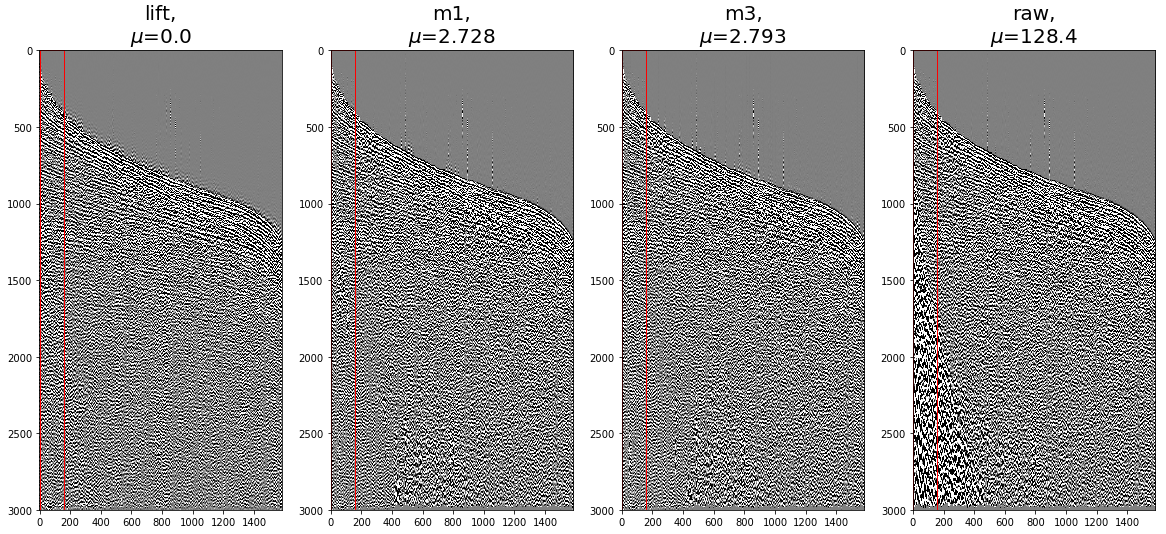

In [13]:
draw_modifications_dist([(lift,'lift'), (m1, 'm1'), (m3, 'm3'), (raw, 'raw')], vmin=-0.1, vmax=0.1, figsize=(20, 10))

In [14]:
res = validate_all(index)

100%|██████████| 101/101 [03:21<00:00,  2.00s/it]


In [15]:
df = pd.DataFrame(res)
df.mean()

lift      0.000000
m1       10.125760
m3        5.604676
raw     193.743267
dtype: float64

In [16]:
df['train']=0
df.iloc[:20]['train']=1

df.groupby('train').mean()

lift         m1        m3         raw
train                                       
0       0.0  11.989073  6.469765  208.049769
1       0.0   2.579339  2.101066  135.801934

In [17]:
res = validate_all(index, traces_frac=200)

100%|██████████| 101/101 [03:13<00:00,  1.91s/it]


In [18]:
df = pd.DataFrame(res)
df.mean()

lift      0.000000
m1        8.680896
m3        4.994756
raw     160.434353
dtype: float64

In [19]:
df['train']=0
df.iloc[:20]['train']=1

df.groupby('train').mean()

lift         m1        m3         raw
train                                       
0       0.0  10.234636  5.745951  170.317672
1       0.0   2.388251  1.952417  120.406913

In [20]:
df.groupby('train').min()

lift        m1        m3        raw
train                                     
0       0.0  1.491332  1.607053  21.678276
1       0.0  0.947879  0.899103  62.330971

In [21]:
df.groupby('train').max()

lift          m1         m3         raw
train                                         
0       0.0  110.800461  48.444004  935.894836
1       0.0    4.859786   4.819836  323.663940

In [22]:
df[df.m1 > 4]

lift          m1         m3         raw  train
3     0.0    4.822452   4.819836  120.346657      1
6     0.0    4.859786   2.603144  100.610382      1
11    0.0    4.389590   2.820996  102.746002      1
20    0.0    4.046701   2.915098  310.197754      0
22    0.0   21.578020  16.182493  218.322556      0
23    0.0    8.168238   3.541515  316.877777      0
25    0.0    4.839227   1.795544  131.353928      0
26    0.0   21.647112   3.660118  193.576736      0
31    0.0   19.494663  48.444004  494.440765      0
35    0.0   30.666363   5.065423  317.725769      0
37    0.0  110.800461  19.296677  935.894836      0
38    0.0   16.827730   2.719306  211.294830      0
42    0.0   21.124640   3.626742  331.865234      0
43    0.0   27.083523  14.449196  318.674683      0
45    0.0   10.831079   3.411179  363.353912      0
46    0.0   11.735098   7.715427  221.011917      0
48    0.0    5.534087   2.717694  274.128632      0
49    0.0   47.051075   7.506415  312.250153      0
51    0.0    8.413777   2.918007  296.576111      0
52    0.0    9.234134   3.168606  161.397720      0
54    0.0   16.002337   3.168523  174.298630      0
55    0.0   32.285507  32.476715  254.448288      0
57    0.0    9.361602  14.835334   94.667961      0
58    0.0    4.560352   2.545040   76.026886      0
59    0.0    6.202317   2.503547  102.677574      0
60    0.0    4.561499  17.275225   68.393288      0
63    0.0   10.684949   3.436188   43.486626      0
65    0.0    8.998767   3.116808   88.645065      0
67    0.0   11.682429   2.976963   89.450577      0
68    0.0   11.116404   3.010411   58.911655      0
69    0.0    4.727880   3.194340   21.678276      0
70    0.0    6.000525   2.980254   44.629147      0
72    0.0    4.819607   4.018212   68.895508      0
73    0.0    4.876580   3.895932   80.024864      0
74    0.0    4.313411   3.605328   49.988930      0
75    0.0    5.404518   4.186582   97.137955      0
76    0.0    4.477064   3.413502   72.758751      0
78    0.0    9.707108  11.348195  124.372360      0
79    0.0    4.059251   3.281602   46.126007      0
80    0.0    8.177090   2.852170  125.840569      0
81    0.0   15.816738  13.934723  369.801880      0
82    0.0    5.455123   3.197337  158.885498      0
83    0.0   13.438765   2.566390  114.688599      0
85    0.0    7.823272   2.935040  126.337944      0
86    0.0    6.726332   3.297248  254.029587      0
87    0.0    4.945003   2.835328  134.419067      0
88    0.0    4.016525   3.156783  144.614807      0
89    0.0   20.196077   3.062040  193.699799      0
91    0.0   36.130302   3.353870  305.566681      0
92    0.0   10.371678   2.996920  201.504562      0
93    0.0    7.158040   3.749957   78.746727      0
94    0.0    5.935267   3.325722  181.407578      0
95    0.0   26.723003  38.765030  292.442108      0
96    0.0    5.394984   4.989061  124.739189      0
97    0.0    6.475574   3.473714  146.425919      0
98    0.0   19.342916   2.584281  245.317429      0
99    0.0    4.241252   3.474983  110.481140      0
100   0.0    5.472353   3.393274  142.584991      0

In [23]:
df[df.m3 > 4]

lift          m1         m3         raw  train
3    0.0    4.822452   4.819836  120.346657      1
22   0.0   21.578020  16.182493  218.322556      0
31   0.0   19.494663  48.444004  494.440765      0
33   0.0    2.533898   7.918845  203.581100      0
35   0.0   30.666363   5.065423  317.725769      0
36   0.0    3.724164   4.684142  331.557983      0
37   0.0  110.800461  19.296677  935.894836      0
40   0.0    3.158858  15.582645  160.361404      0
43   0.0   27.083523  14.449196  318.674683      0
46   0.0   11.735098   7.715427  221.011917      0
49   0.0   47.051075   7.506415  312.250153      0
55   0.0   32.285507  32.476715  254.448288      0
57   0.0    9.361602  14.835334   94.667961      0
60   0.0    4.561499  17.275225   68.393288      0
72   0.0    4.819607   4.018212   68.895508      0
75   0.0    5.404518   4.186582   97.137955      0
78   0.0    9.707108  11.348195  124.372360      0
81   0.0   15.816738  13.934723  369.801880      0
95   0.0   26.723003  38.765030  292.442108      0
96   0.0    5.394984   4.989061  124.739189      0

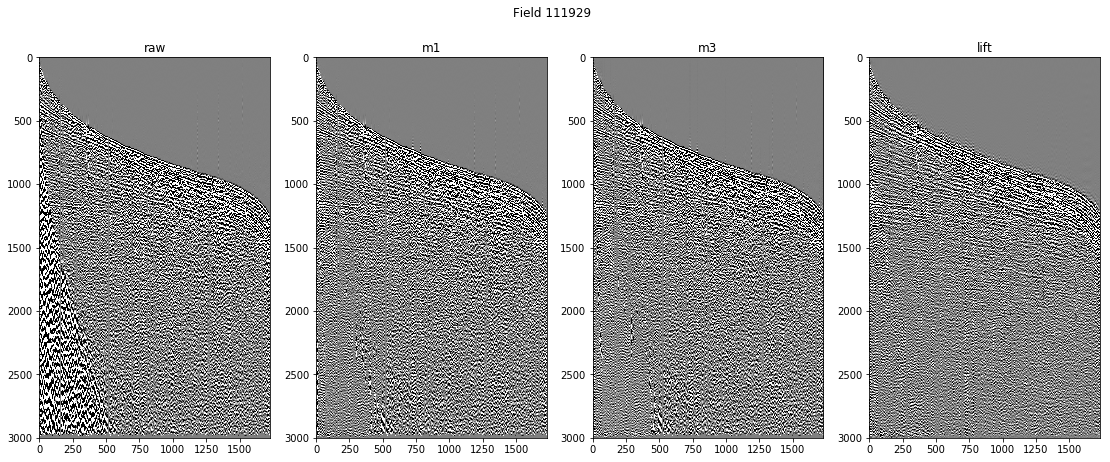

In [24]:
arrs = check_res(22, index)

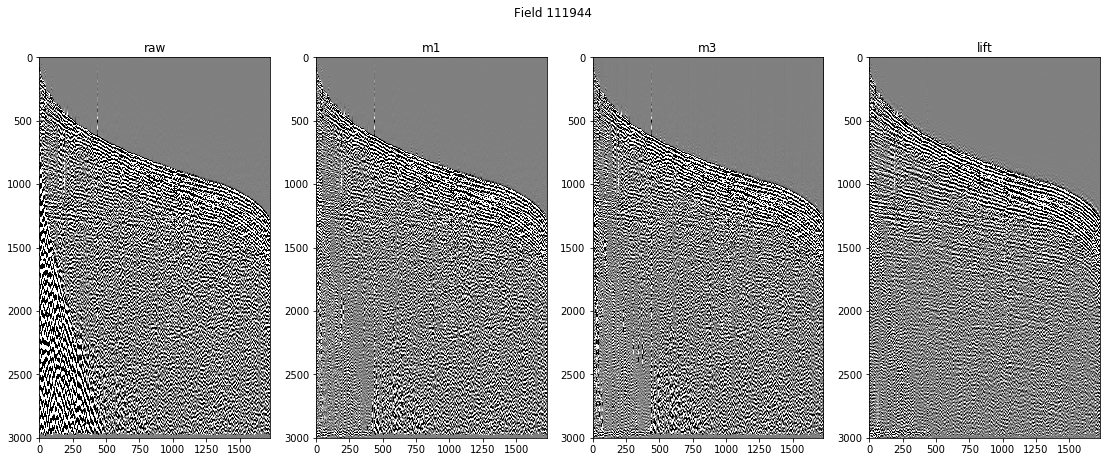

In [25]:
arrs = check_res(37, index)

In [26]:
df[df.m1 < 1]

lift        m1        m3         raw  train
13   0.0  0.998589  1.112464  148.268921      1
15   0.0  0.947879  0.899103   99.351410      1

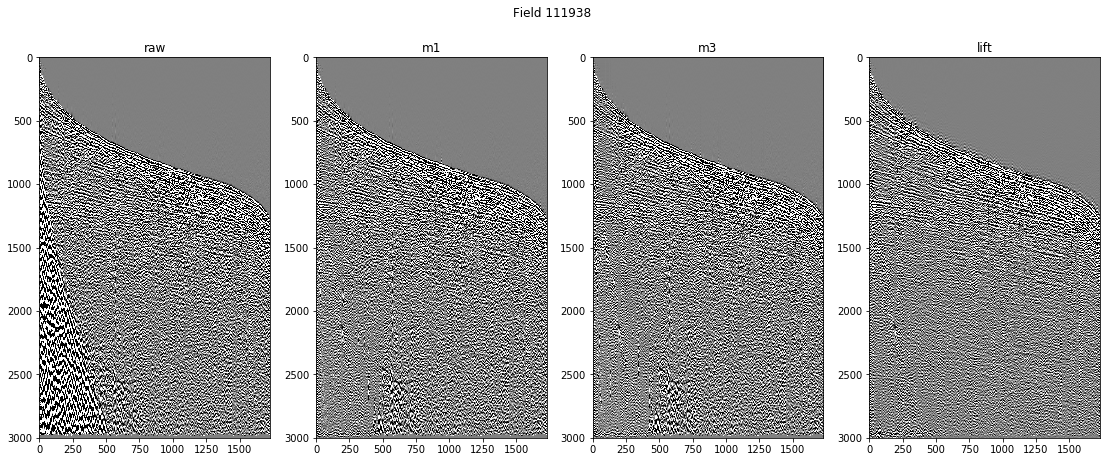

In [27]:
arrs = check_res(31, index)